In [4]:
import pandas as pd

In [5]:
covid_data = pd.read_csv('/Users/yanaprynik/Work_doc/covid19/covid_data.csv')
vaccinations_data = pd.read_csv('/Users/yanaprynik/Work_doc/covid19/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
display(covid_data)

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0
...,...,...,...,...,...,...
306424,05/29/2021,Zaporizhia Oblast,Ukraine,102641.0,2335.0,95289.0
306425,05/29/2021,Zeeland,Netherlands,29147.0,245.0,0.0
306426,05/29/2021,Zhejiang,China,1364.0,1.0,1324.0
306427,05/29/2021,Zhytomyr Oblast,Ukraine,87550.0,1738.0,83790.0


	
В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.

В таблицах не совпадает число стран, а иногда и их названия. 

При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.

Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

Для таблицы covid_data сделаем следующее:

Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [6]:
covid_data = covid_data.groupby(['date', 'country'], as_index=False)[['confirmed', 'deaths', 'recovered']].sum()

Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [7]:
covid_data['date'] = pd.to_datetime(covid_data['date'],dayfirst=False)

Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [8]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по датам, а затем по названиям стран. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [9]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [10]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

In [11]:
covid_df = pd.merge(covid_data, vaccinations_data, on=['date','country'], how='left')

In [12]:
covid_df['death_rate'] = covid_df['deaths'] / covid_df['confirmed'] * 100
covid_df['recover_rate'] = covid_df['recovered'] / covid_df['confirmed'] * 100


In [13]:
max_death_rate_usa = covid_df[covid_df['country'] == 'United States']['death_rate'].max()
recover_rate_in_russia = covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()
display(round(recover_rate_in_russia,2))

67.06

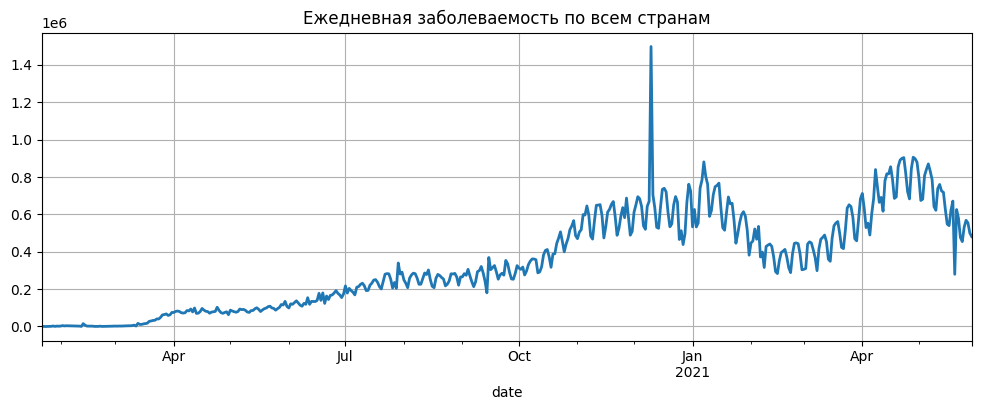

In [14]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость по всем странам',
    grid = True,
    lw=2
);

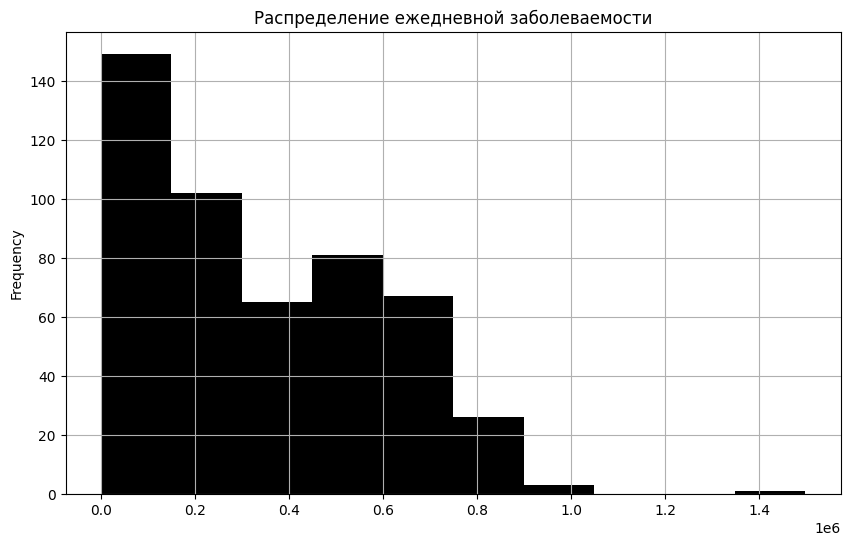

In [15]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
);

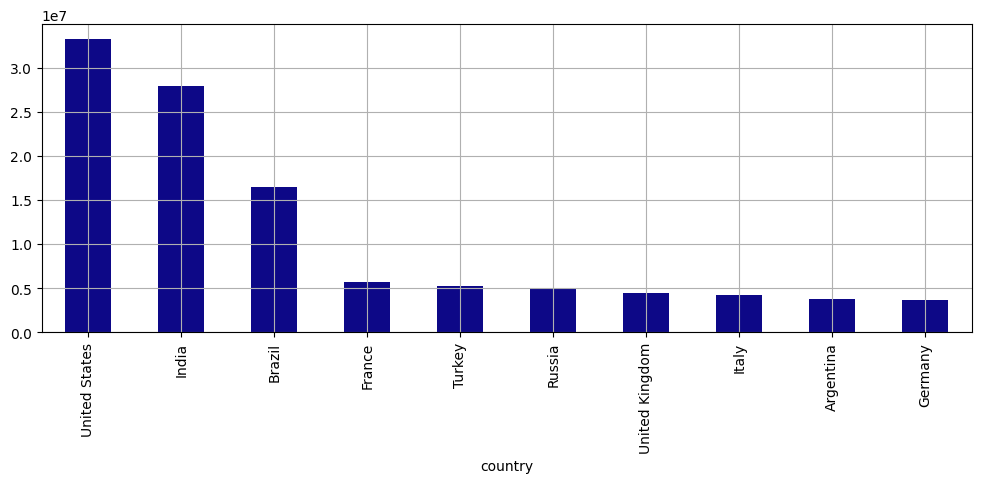

In [37]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

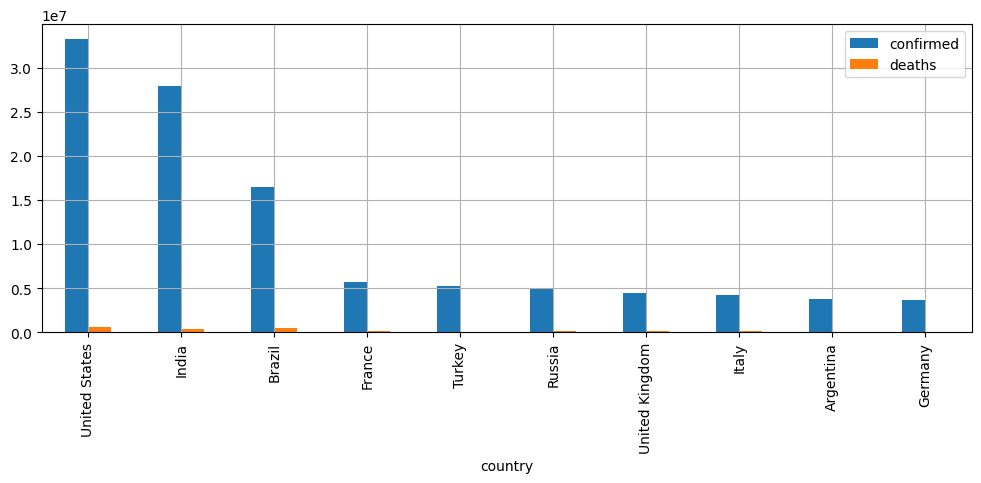

In [17]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4)
);

<Axes: xlabel='country'>

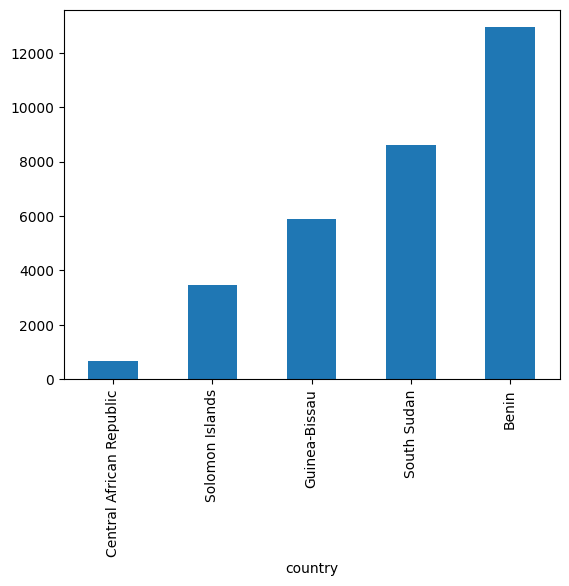

In [18]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar')

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

Процесс работы над графиком максимально прозрачен: сначала создаётся объект фигуры (fig) , содержащий необходимую информацию и настройки, например размер в дюймах (b>figsize, восемь дюймов в ширину, четыре — в высоту). К этому объекту с помощью метода add_axes() добавляется координатная плоскость, а на ней располагаются графические объекты. Для создания координатной плоскости необходимо указать её расположение на фигуре в виде списка из координат. В нашем случае она начинается в левом нижнем углу без отступов (координаты 0, 0) и занимает всё отведённое место в области (100%, ширина и высота равны 1).

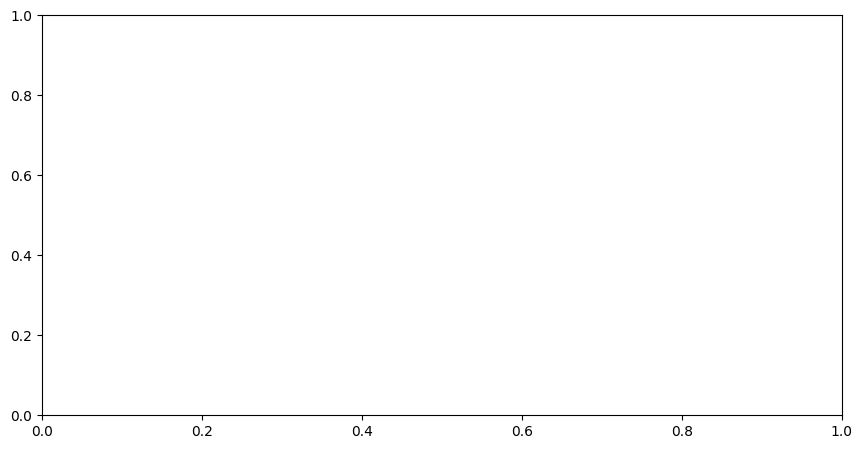

In [20]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

Теперь на созданной системе координат мы можем построить график. 

Утверждается, что коллективная вакцинация позволяет минимизировать риск заражения коронавирусной инфекцией (но только после второго компонента). Давайте проверим это на примере США: построим диаграмму рассеяния, которая покажет зависимость числа ежедневно обнаруживаемых случаев заражения (daily_confirmed) от общего количества привитых вторым компонентом вакцины (people_fully_vaccinated) в США.

У объекта координатной плоскости axes вызовем метод scatter().

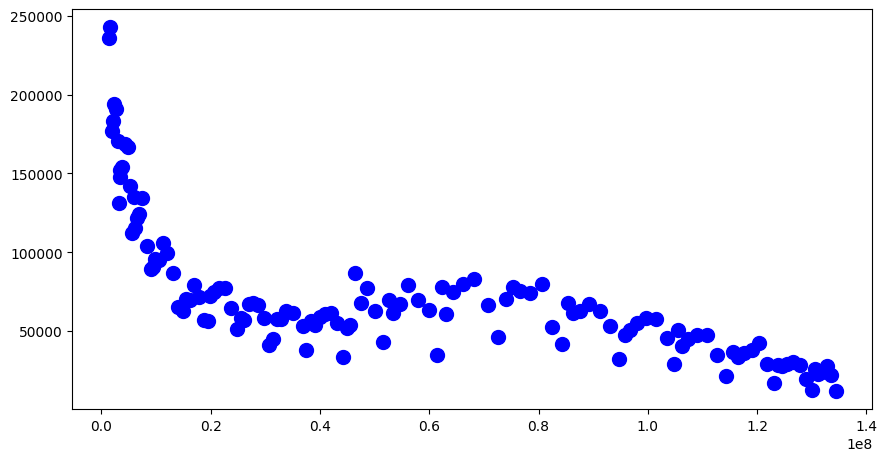

In [21]:
us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

Топ-10 вакцин (vaccines) по распространённости мы находим с помощью метода value_counts(). Круговую диаграмму строим на полученных значениях, метки для каждого значения — индексы промежуточной таблицы. Будем отображать доли в процентах и округлять их до одного знака после запятой. Самую распространённую вакцину сместим на 10 % от центра:

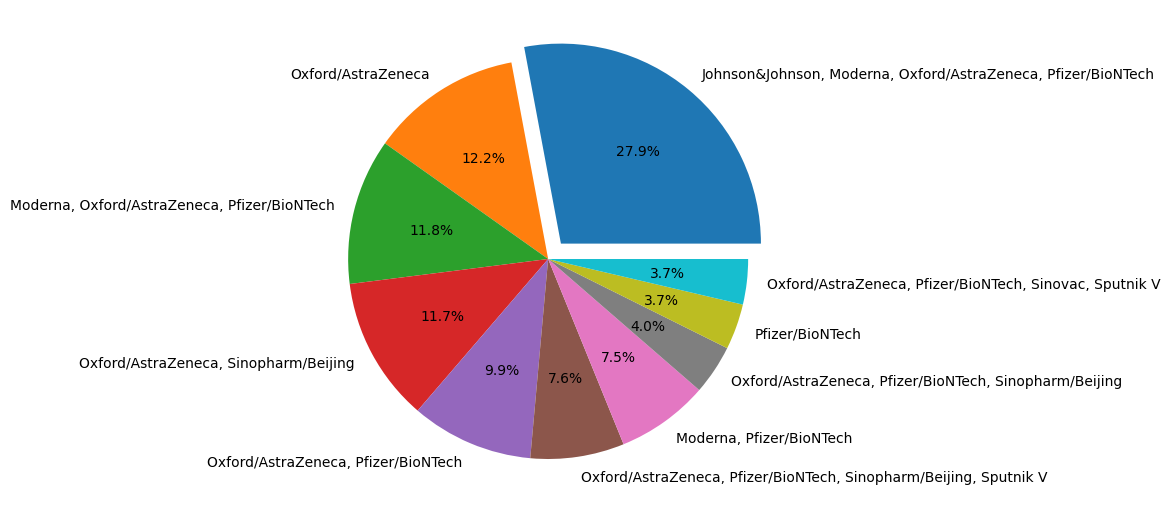

In [22]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

Например, изобразим на одном графике, как росла общая заболеваемость (confirmed), число зафиксированных смертей (deaths), выздоровевших пациентов (recovered) и активных случаев (active) в Китае.

Для построения линейных графиков в Matplotlib используется метод plot()

Важно! Не путайте его с методом plot() в Pandas!

При вызове метода без параметров по оси ординат откладываются значения столбца таблицы, по оси абсцисс — индексы (в нашем случае это будут даты). 

Дополнительно в параметрах метода указываем параметр label — название графика, которое будет отображаться на легенде, а также lw — ширину линии графика. Добавим к графику заголовок, названия осей, установим метки по оси y с частотой в 10 000, повернём метки по оси x на 30 градусов, а также добавим легенду (метки для легенды выставляются в параметре label метода plot()):

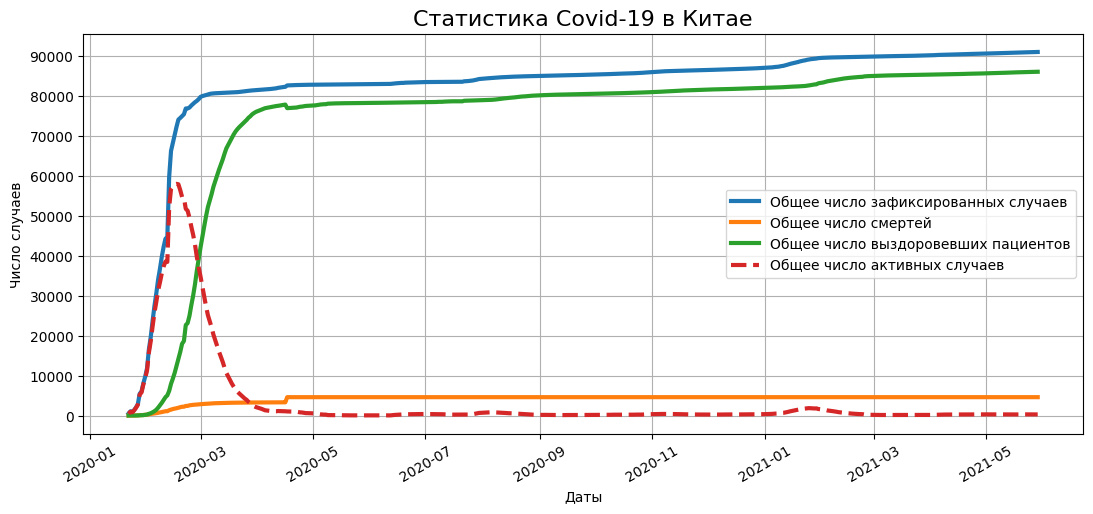

In [23]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

Важно! Вы можете размещать несколько систем координат на одной фигуре, что позволит нам отображать вспомогательную информацию на основном графике. Для добавления второй системы координат необходимо повторно применить к объекту fig метод add_axes, указав новое имя для второй системы координат.

Группируем таблицу по странам, находим последний по дате зафиксированный показатель с помощью метода last() и выбираем ТОП-5 стран с использованием метода nlargest().
При отображении графиков создаём две координатные плоскости main_axes и insert_axes, на каждой из них отдельно строим столбчатые диаграммы.

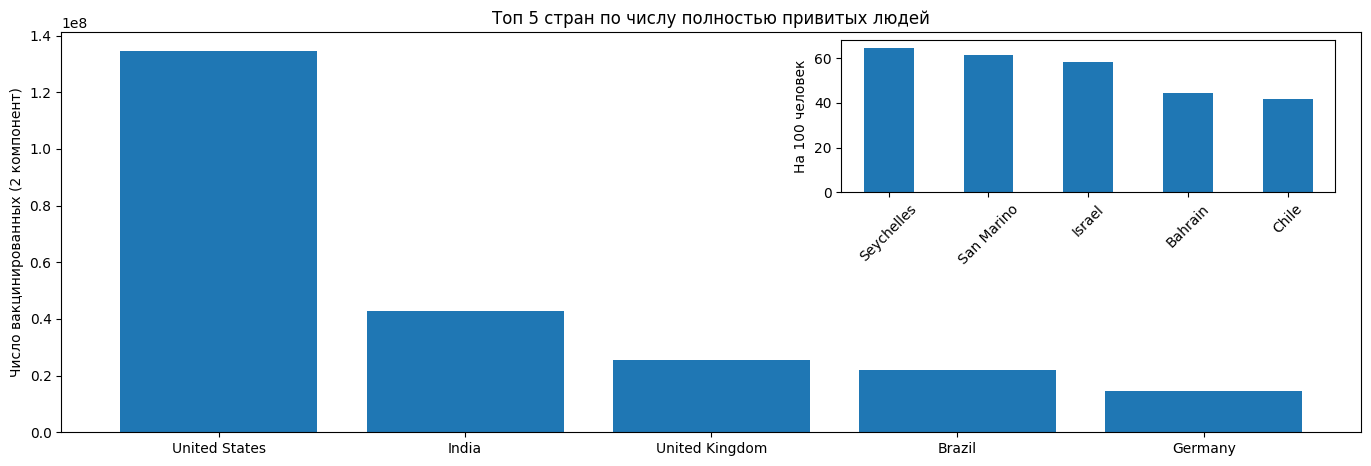

In [24]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

Создание дополнительных систем координат с помощью метода add_axes() полезно, однако используется не так часто.

В большинстве случаев для отображения нескольких систем координат используется функция subplots(). Она создаёт целую таблицу из систем координат на одной фигуре. Функция возвращает новую фигуру, а также список координатных плоскостей.

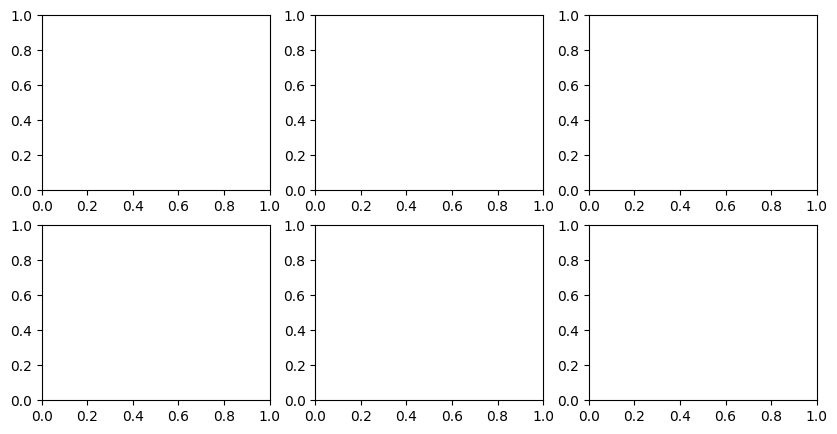

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

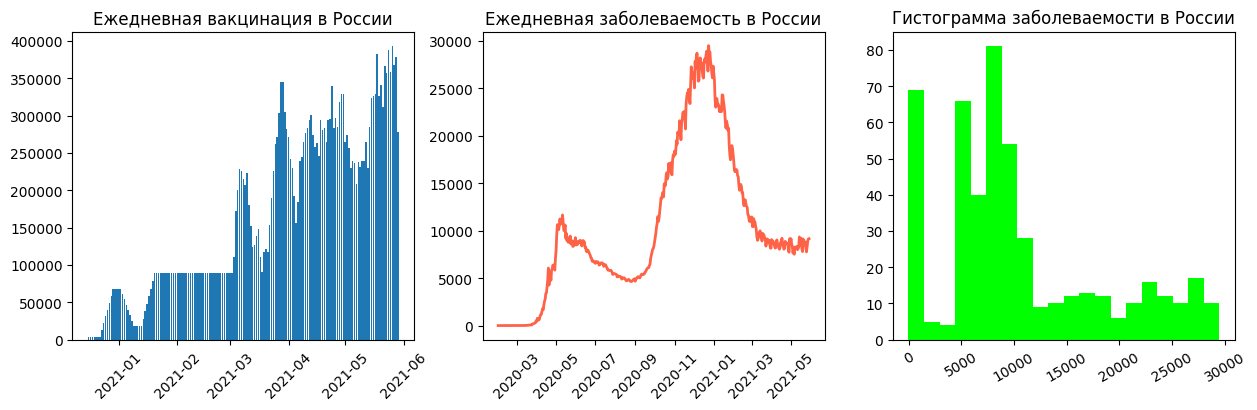

In [26]:
russia_data = covid_df[covid_df['country'] == 'Russia']

#визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

#столбчатая диаграмма
axes[0].bar(x=russia_data['date'], 
    height=russia_data['daily_vaccinations'],
    label='Число вакцинированных'
)
axes[0].set_title('Ежедневная вакцинация в России')
axes[0].xaxis.set_tick_params(rotation=45)

#линейный график
axes[1].plot(russia_data['date'],
    russia_data['daily_confirmed'],
    label='Число заболевших',
    color='tomato', lw=2
)
axes[1].set_title('Ежедневная заболеваемость в России')
axes[1].xaxis.set_tick_params(rotation=45)

#гистограмма
axes[2].hist(x=russia_data['daily_confirmed'],
    label=['Число заболевших'], 
    color='lime', bins = 20
)
axes[2].set_title('Гистограмма заболеваемости в России')
axes[2].xaxis.set_tick_params(rotation=30)

Мы рассмотрели лишь основные графики и их настройки в библиотеке Matplotlib. На самом деле библиотека имеет гораздо больший спектр возможностей, на изучение которого не хватит даже целого курса по визуализации, — от добавления текста на диаграмму до визуализации изображений и 3D-графиков.

Также стоит отметить, что, помимо объектно-ориентированного подхода в работе с библиотекой Matplotlib, вы можете встретить и модульный подход.

Модульный подход основан на обращении к модулю pyplot (plt) напрямую, а не средствами объектов фигур и плоскостей. Например, следующий код строит столбчатую диаграмму: по оси x откладываются элементы списка names (названия групп), а высоту столбцов определяет список values.

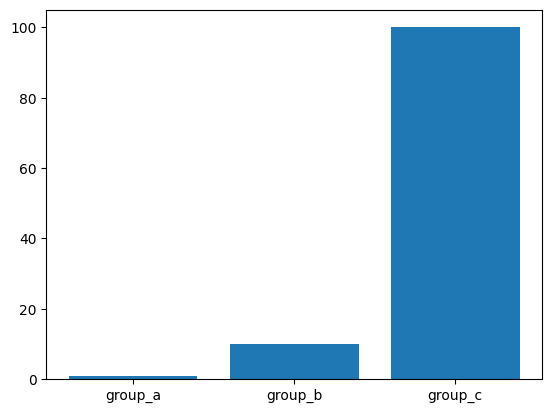

In [27]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]
plt.bar(names, values)
plt.show()

<BarContainer object of 5 artists>

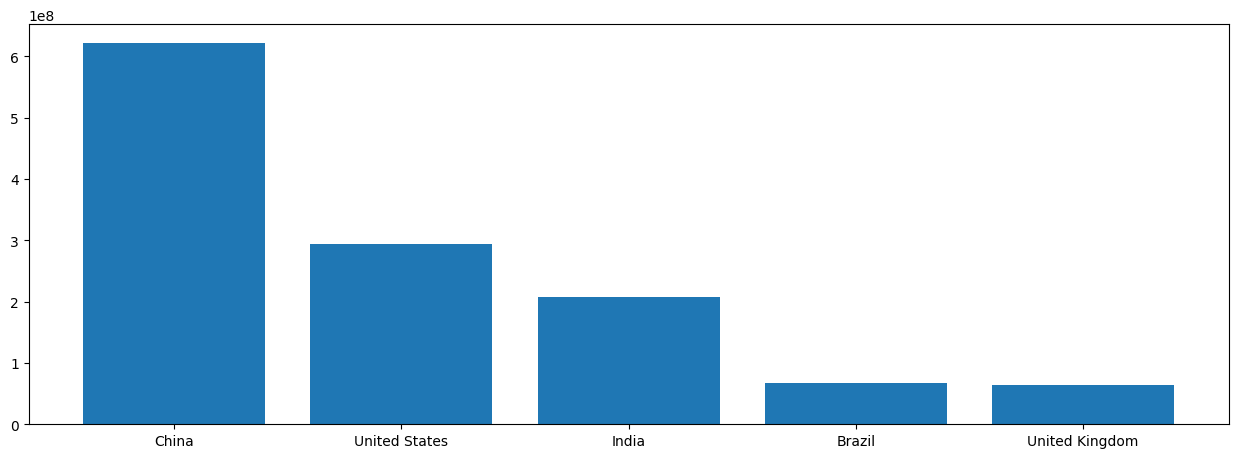

In [28]:
v = covid_df.groupby(['country'])['total_vaccinations'].last().nlargest(5)
fig = plt.figure(figsize=(12, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=v.index,height=v)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.__version__

'0.12.2'

In [30]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()


,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


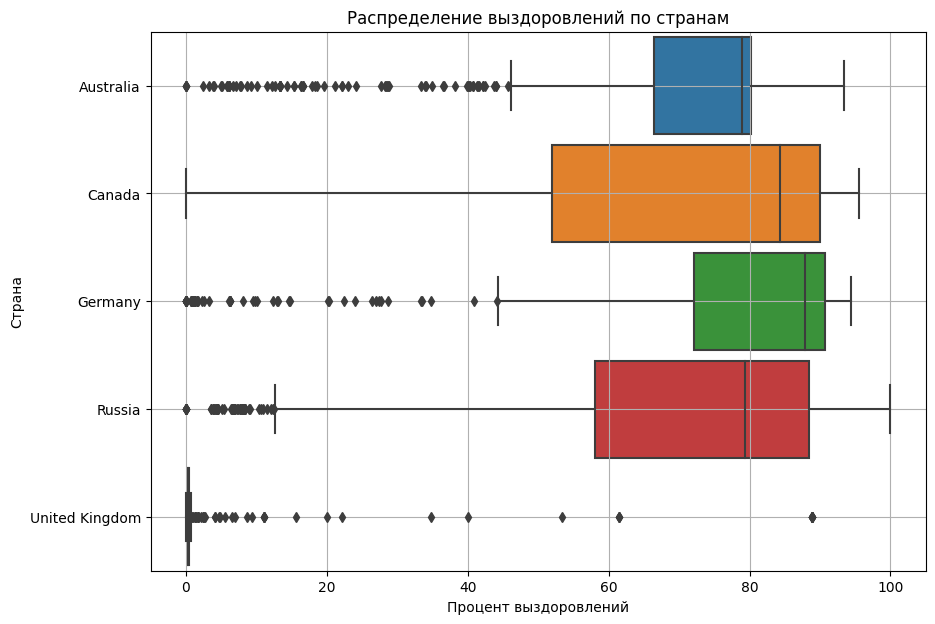

In [31]:

fig2 = plt.figure(figsize=(10, 7))
recover_rate = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9
)
recover_rate.set_title('Распределение выздоровлений по странам');
recover_rate.set_xlabel('Процент выздоровлений');
recover_rate.set_ylabel('Страна');
recover_rate.grid()

In [32]:
!pip3 install plotly


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip3 install --upgrade pip


In [33]:
import plotly
import plotly.express as px

In [34]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86785 entries, 0 to 86784
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[ns]
 1   country                              86785 non-null  object        
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vac

In [35]:
line_data = covid_df.groupby(by='date', as_index=False)['daily_vaccinations'].sum()
fig = px.line(data_frame=line_data, x='date', y='daily_vaccinations')
fig.show()
